# Decision Tree Models para el mercado inmobiliario

En el presente notebook investigamos distintos tipos de modelos basados en árboles de decisión para predecir los valores de las propiedades en el mercado inmobiliario de Buenos Aires. Los árboles de decisión y sus ensambles tienen la capacidad de generar buenos ajustes en datasets heterogéneos y complejos como el que trabajamos aquí. La información ha sido extraída de [Properati](https://www.properati.com.ar/data/).

Empezamos por importar librerías, y acomodar el dataset para su posterior modelado.

In [1]:
import os
# import warnings
# warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Properati_data_clean.csv')
df.head()

,index,created_on,lat,lon,barrio_publicado,rooms,surface_total,surface_covered,price,title,...,VILLA LURO,VILLA ORTUZAR,VILLA PUEYRREDON,VILLA REAL,VILLA RIACHUELO,VILLA SANTA RITA,VILLA SOLDATI,VILLA URQUIZA,surface_uncovered,price_m2
0,0,2019-08-04,-34.601864,-58.443563,Villa Crespo,3.0,67.0,60.0,110000.0,Departamento venta,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1732.283465
1,1,2019-08-04,-34.644735,-58.421061,Boedo,2.0,40.0,40.0,79900.0,Departamento - Boedo - 2 amb MUY LUMINOSO!! ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997.500000
2,2,2019-08-04,-34.603423,-58.431140,Almagro,2.0,38.0,38.0,112000.0,Dos Ambientes Reciclado a 1 cuadra del Subte B,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2947.368421
3,3,2019-08-04,-34.609326,-58.492374,Villa del Parque,2.0,94.0,77.0,169000.0,PH DE 3 PLANTAS CON COCHERA PROPIA Y TERRAZA,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1976.608187
4,4,2019-05-27,-34.629607,-58.439279,NaN,1.0,41.0,37.0,118000.0,Departamento venta,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3025.641026


In [3]:
# Chequeo columnas
df.columns

Index(['index', 'created_on', 'lat', 'lon', 'barrio_publicado', 'rooms',
       'surface_total', 'surface_covered', 'price', 'title', 'description',
       'property_type', 'barrio', 'densidad', 'NBI', 'Casa', 'Departamento',
       'PH', 'AGRONOMIA', 'ALMAGRO', 'BALVANERA', 'BARRACAS', 'BELGRANO',
       'BOCA', 'BOEDO', 'CABALLITO', 'CHACARITA', 'COGHLAN', 'COLEGIALES',
       'CONSTITUCION', 'FLORES', 'FLORESTA', 'LINIERS', 'MATADEROS',
       'MONSERRAT', 'MONTE CASTRO', 'NUEVA POMPEYA', 'NUNEZ', 'PALERMO',
       'PARQUE AVELLANEDA', 'PARQUE CHACABUCO', 'PARQUE CHAS',
       'PARQUE PATRICIOS', 'PATERNAL', 'PUERTO MADERO', 'RECOLETA', 'RETIRO',
       'SAAVEDRA', 'SAN CRISTOBAL', 'SAN NICOLAS', 'SAN TELMO',
       'VELEZ SARSFIELD', 'VERSALLES', 'VILLA CRESPO', 'VILLA DEL PARQUE',
       'VILLA DEVOTO', 'VILLA GRAL. MITRE', 'VILLA LUGANO', 'VILLA LURO',
       'VILLA ORTUZAR', 'VILLA PUEYRREDON', 'VILLA REAL', 'VILLA RIACHUELO',
       'VILLA SANTA RITA', 'VILLA SOLDATI', 'VILLA U

In [4]:
# Me quedo con las columnas que me interesan
features = ['lat', 'lon','surface_covered','surface_uncovered','rooms','NBI','densidad','Casa', 'Departamento','PH',]
barrios = ['BALVANERA','VILLA LUGANO','CONSTITUCION','FLORES','BOCA','NUNEZ','BELGRANO','RECOLETA','PALERMO']
targets = ['price_m2','price',]
columnas = features + barrios + targets
df = df[columnas]
df.head()

,lat,lon,surface_covered,surface_uncovered,rooms,NBI,densidad,Casa,Departamento,PH,...,VILLA LUGANO,CONSTITUCION,FLORES,BOCA,NUNEZ,BELGRANO,RECOLETA,PALERMO,price_m2,price
0,-34.601864,-58.443563,60.0,7.0,3.0,0.74,21699.484109,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1732.283465,110000.0
1,-34.644735,-58.421061,40.0,0.0,2.0,5.80,11797.712026,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997.500000,79900.0
2,-34.603423,-58.431140,38.0,0.0,2.0,0.92,63288.443473,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2947.368421,112000.0
3,-34.609326,-58.492374,77.0,17.0,2.0,0.27,13914.638078,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1976.608187,169000.0
4,-34.629607,-58.439279,37.0,4.0,1.0,6.03,20216.713377,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3025.641026,118000.0


In [5]:
df.dropna(inplace=True)
df.isna().sum()

lat                  0
lon                  0
surface_covered      0
surface_uncovered    0
rooms                0
NBI                  0
densidad             0
Casa                 0
Departamento         0
PH                   0
BALVANERA            0
VILLA LUGANO         0
CONSTITUCION         0
FLORES               0
BOCA                 0
NUNEZ                0
BELGRANO             0
RECOLETA             0
PALERMO              0
price_m2             0
price                0
dtype: int64

### Train/Test Split

In [6]:
from sklearn.model_selection import train_test_split

# Shuffleamos
np.random.seed(seed=49)
df_perm = np.random.permutation(df)
df = pd.DataFrame(df_perm,columns=df.columns)

# Vamos a dividir en tres conjuntos: train, validation, test
df_train, df_val_test = train_test_split(df,test_size=0.3,random_state=50)
df_validation, df_test = train_test_split(df_val_test,test_size=0.5,random_state=51)

In [7]:
# Tomaremos como target la variable precio, y como input todo lo demás
X_train = df_train.drop(columns=['price','price_m2'])
X_validation = df_validation.drop(columns=['price','price_m2'])
X_test = df_test.drop(columns=['price','price_m2'])
y_train = df_train['price']
y_validation = df_validation['price'] 
y_test = df_test['price']

### Decision Tree

Empezamos por utilizar la versión más elemental de esta familia de modelos: el árbol de decisión. Es probable que no constituya nuestro modelo demasiado bueno, pero servirá de benchmark para ir mejorando nuestras predicciones. Comenzaremos con los parámetros default de sci-kit learn.

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score

tree1 = DecisionTreeRegressor(random_state=52)
tree1.fit(X_train,y_train)
y_pred1 = tree1.predict(X_test)
rmse1 = np.sqrt(mean_squared_error(y_test,y_pred1))
r2_tree1 = r2_score(y_test,y_pred1)
print(f"RMSE: {rmse1}")
print(f"R2: {r2_tree1}")

RMSE: 38414.350877578
R2: 0.7860361339131262


### Decision Tree: optimización de hiperparámetros

In [9]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate

# Parámetros a considerar: criterion, splitter, max_depth (regularizador)
param_grid1 = {'splitter':['best','random'],'max_depth':[10,50,100],\
              'max_features':[4,8,len(X_train.columns)],}

grid_tree1 = GridSearchCV(tree1,param_grid1,scoring='neg_mean_squared_error',cv=5)
grid_tree1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=52,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [10, 50, 100], 'max_features': [4, 8, 19],
                         'splitter': ['best', 'random']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,

In [10]:
# Creamos un dataframe con los resultados
df_scores1 = pd.DataFrame(grid_tree1.cv_results_)
# Lo tuneamos un poquito
df_scores1 = df_scores1[['mean_test_score','rank_test_score','param_splitter','param_max_depth','param_max_features']]
df_scores1['rmse'] = np.sqrt(-df_scores1['mean_test_score'])
df_scores1 = df_scores1.sort_values('rank_test_score').head(7)
# A ver...
df_scores1

,mean_test_score,rank_test_score,param_splitter,param_max_depth,param_max_features,rmse
4,-1.452838e+09,1,best,10,19,38116.106027
2,-1.589863e+09,2,best,10,8,39873.089683
8,-1.720033e+09,3,best,50,8,41473.279350
14,-1.720033e+09,3,best,100,8,41473.279350
10,-1.733515e+09,5,best,50,19,41635.503346
16,-1.733515e+09,5,best,100,19,41635.503346
5,-1.744038e+09,7,random,10,19,41761.681289


Vamos entonces a hilar más fino en el tuning de los hiperparámetros. El "splitter" lo dejaremos en best, pero veamos qué sucede con max_features (alrededor del 10) y max_depth.

In [11]:
param_grid3 = {'max_depth':[6,8,9,10,11,12,15,20],'max_features':[8,13,19],}

grid_tree3 = GridSearchCV(tree1,param_grid3,scoring='neg_mean_squared_error',cv=5)
grid_tree3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=52,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [6, 8, 9, 10, 11, 12, 15, 20],
                         'max_features': [8, 13, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

In [12]:
df_scores3 = pd.DataFrame(grid_tree3.cv_results_)
df_scores3 = df_scores3[['mean_test_score','rank_test_score','param_max_depth','param_max_features']]
df_scores3['rmse'] = np.sqrt(-df_scores3['mean_test_score'])
df_scores3 = df_scores3.sort_values('rank_test_score')
df_scores3.head(7)

,mean_test_score,rank_test_score,param_max_depth,param_max_features,rmse
8,-1.448435e+09,1,9,19,38058.315624
11,-1.452838e+09,2,10,19,38116.106027
5,-1.463462e+09,3,8,19,38255.225286
4,-1.479444e+09,4,8,13,38463.547469
10,-1.487149e+09,5,10,13,38563.569730
7,-1.497074e+09,6,9,13,38692.037847
14,-1.498054e+09,7,11,19,38704.697249


Gráficamente:

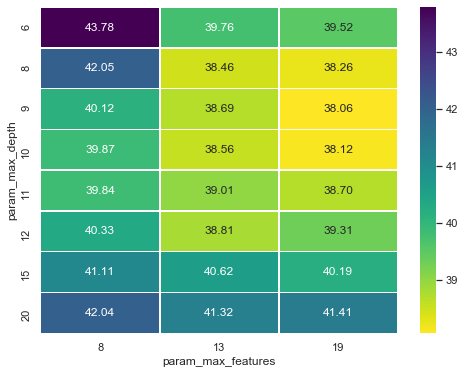

In [13]:
sns.set()
df_heat = df_scores3.groupby(['param_max_depth','param_max_features'])
df_heat = df_heat['rmse'].sum().unstack()
# Lo paso a miles
df_heat = round((df_heat / 1000),4)
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_heat, annot=True, fmt='.2f', linewidths=.5, cmap='viridis_r', ax=ax)

Tenemos un ganador: max_features = 19 (el total de features) y max_depth = 9. Veamos su performance.

In [14]:
y_pred2 = grid_tree3.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test,y_pred2))
r2_tree2 = r2_score(y_test,y_pred2)
print(f"RMSE: {rmse2}")
print('Mejora RMSE benchmark: %.2f'% (((rmse1 - rmse2)/rmse1)*100)+'%')
print(f"R2: {r2_tree2}")

RMSE: 36867.30425047201
Mejora RMSE benchmark: 4.03%
R2: 0.8029228810703972


### Random Forest Regressor

A continuación entrenamos un modelo más poderoso, Random Forest. El procedimiento será similar al apartado anterior.

In [15]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=52,n_jobs=-1)
rfr.fit(X_train,y_train)
y_train_pred4 = rfr.predict(X_train)
y_test_pred4 = rfr.predict(X_test)
rmse_train4 = np.sqrt(mean_squared_error(y_train,y_train_pred4))
rmse_test4 = np.sqrt(mean_squared_error(y_test,y_test_pred4))
print(f'RMSE train: {rmse_train4}')
print(f'RMSE test: {rmse_test4}')
print('Mejora benchmark: %.2f'% (((rmse1 - rmse_test4)/rmse1)*100)+' %')

C:\Users\Usuario\Python\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE train: 13184.930649023807
RMSE test: 30242.425492227205
Mejora benchmark: 21.27 %


Pese a la sustancial mejora respecto de nuestro benchmark, tenemos un enorme grado de overfitting. A continuación haremos Grid Search con cross validation para seguir mejorando la performance.

In [16]:
forest_grid = {'n_estimators':[30,50,70,100,120,150],'max_depth':[None,5,10,20,30,50]}
# cv=2 por el tiempo de espera, luego se puede ajustar
rnr_grid = GridSearchCV(rfr,forest_grid,cv=2,scoring='neg_mean_squared_error',return_train_score=True).fit(X_train,y_train)

In [17]:
rnrgrid_df1 = pd.DataFrame(rnr_grid.cv_results_)
rnrgrid_df1 = rnrgrid_df1[['param_max_depth','param_n_estimators',\
                    'mean_test_score','rank_test_score','mean_fit_time']]
rnrgrid_df1 = rnrgrid_df1
rnrgrid_df1['rmse_test'] = np.sqrt(-rnrgrid_df1['mean_test_score'])
# Veamos una muestra
rnrgrid_df1.sort_values(by='rank_test_score').head(7)

,param_max_depth,param_n_estimators,mean_test_score,rank_test_score,mean_fit_time,rmse_test
23,20,150,-1.034626e+09,1,2.347569,32165.602834
29,30,150,-1.035890e+09,2,2.299994,32185.251825
22,20,120,-1.036051e+09,3,1.833591,32187.750936
5,None,150,-1.036071e+09,4,3.069993,32188.052548
35,50,150,-1.036071e+09,4,2.731476,32188.052548
28,30,120,-1.037086e+09,6,1.912346,32203.812553
34,50,120,-1.037323e+09,7,1.653170,32207.501949


Gráficamente:

In [18]:
# Convierto los None a string para que pandas los tabule
rnrgrid_df1.fillna('None',inplace=True)
# Creo una tabla tipo pivot con mis parámetros
table = rnrgrid_df1.groupby(['param_max_depth','param_n_estimators'])['rmse_test'].sum().unstack()
table = round(table/1000,2)

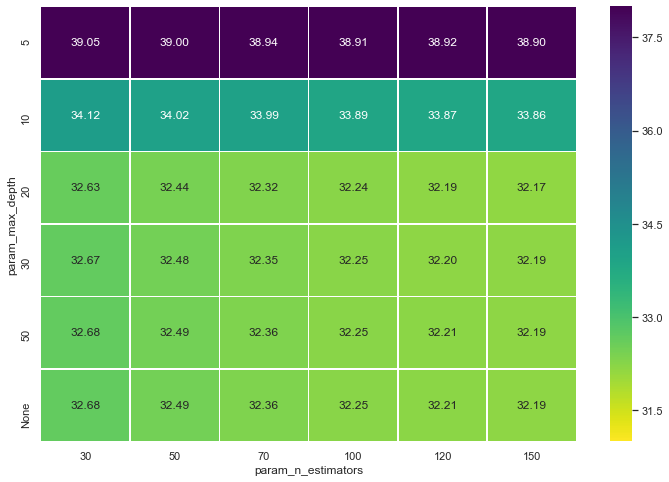

In [19]:
# Grid Search Heatmap
sns.set()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(table, annot=True, fmt='.2f',linewidths=.5, cmap='viridis_r', ax=ax, vmin=31, vmax=38)

El RMSE disminuye a medida que nos movemos hacia abajo (mayor max_depth) y hacia la derecha (mayor n_estimators). A partir de una profunidad de 20 o 30 la ganancia es cada vez más reducida. A continuación haremos un Grid Search con más parámetros.

In [20]:
forest_grid2 = {'max_depth':[30,50],'max_features':[5,8,11],'n_estimators':[150],'min_samples_split':[2,5,10,20,50]}
rnr_grid2 = GridSearchCV(rfr,forest_grid2,cv=2,scoring='neg_mean_squared_error',return_train_score=True).fit(X_train,y_train)

In [21]:
rnrgrid_df2 = pd.DataFrame(rnr_grid2.cv_results_)
rnrgrid_df2 = rnrgrid_df2[['param_max_depth','param_n_estimators',\
                'param_min_samples_split', 'param_max_features',\
                    'mean_test_score','rank_test_score','mean_fit_time']]
rnrgrid_df2['rmse_test'] = np.sqrt(-rnrgrid_df2['mean_test_score'])
rnrgrid_df2 = rnrgrid_df2.drop(columns=['mean_test_score'])
# Veamos una muestra
rnrgrid_df2.sort_values(by='rank_test_score').head(7)

,param_max_depth,param_n_estimators,param_min_samples_split,param_max_features,rank_test_score,mean_fit_time,rmse_test
20,50,150,2,8,1,1.790809,31711.561887
5,30,150,2,8,2,1.409920,31729.450904
15,50,150,2,5,3,1.217680,31800.095539
0,30,150,2,5,4,1.099881,31807.217153
10,30,150,2,11,5,1.448090,31811.545744
25,50,150,2,11,6,1.515313,31813.733039
11,30,150,5,11,7,1.389547,31997.005405


In [22]:
# Hilando un poco más fino
forest_grid3 = {'max_depth':[30,40,50],'max_features':[7,8,9],'n_estimators':[150,200,300],'min_samples_split':[2]}
rnr_grid3 = GridSearchCV(rfr,forest_grid3,cv=2,scoring='neg_mean_squared_error',return_train_score=True).fit(X_train,y_train)

In [23]:
rnrgrid_df3 = pd.DataFrame(rnr_grid3.cv_results_)
rnrgrid_df3 = rnrgrid_df3[['param_max_depth','param_n_estimators',\
                'param_min_samples_split', 'param_max_features',\
                    'mean_test_score','rank_test_score','mean_fit_time']]
rnrgrid_df3['rmse_test'] = np.sqrt(-rnrgrid_df3['mean_test_score'])
rnrgrid_df3 = rnrgrid_df3.drop(columns=['mean_test_score'])
# Veamos una muestra
rnrgrid_df3.sort_values(by='rank_test_score').head(7)

,param_max_depth,param_n_estimators,param_min_samples_split,param_max_features,rank_test_score,mean_fit_time,rmse_test
2,30,300,2,7,1,2.929157,31575.941423
20,50,300,2,7,2,2.374600,31578.026973
11,40,300,2,7,2,3.052882,31578.026973
23,50,300,2,8,4,4.015696,31600.975066
14,40,300,2,8,4,2.693529,31600.975066
1,30,200,2,7,6,1.397710,31601.239603
0,30,150,2,7,7,1.359040,31608.692038


Como vemos, las ganancias son cada vez más exiguas. Nos quedaremos entonces con los parámetros óptimos del último Grid Search.

In [24]:
rnr_grid3.best_params_

{'max_depth': 30,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 300}

Podría estimarse el modelo directamente desde el Grid Search fiteado, pero para calcular luego la feature importance necesito una instancia del Random Forest Regressor.

In [25]:
rfr_opt = RandomForestRegressor(max_depth=30,max_features=7,
                                 min_samples_split=2,n_estimators=300)
rfr_opt.fit(X_train,y_train)
y_pred_rf = rfr_opt.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test,y_pred_rf))
print(f'RMSE test (Random Forest óptimo): {rmse_rf}')
print('Mejora benchmark: %.2f'% (((rmse1 - rmse_rf)/rmse1)*100)+' %')

RMSE test (Random Forest óptimo): 28102.230375132356
Mejora benchmark: 26.84 %


Una gran ventaja del modelo Random Forest (y de los modelos de árboles de decisión en general) es que tienen un alto grado de interpretabilidad. En particular, poseen una métrica, <b>feature importance</b>, que nos permite entender cuáles son los features que más importancia tienen en la regresión. A continuación la estudiaremos.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text xticklabel objects>)

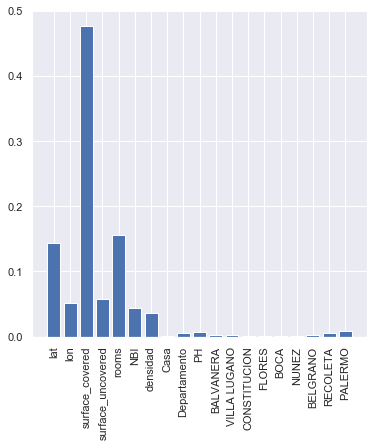

In [26]:
importance = rfr_opt.feature_importances_
Xcolumns = X_train.columns
plt.figure(figsize=(6,6))
plt.bar(Xcolumns,importance)
plt.xticks(rotation=90)

De aquí surgen algunas observaciones interesantes: en primer lugar, y como es esperable, las variables más importantes son las de superficie; por lejos la superficie total es el factor que más explica el precio de una propiedad. En segundo lugar, se nota la asimetría de las coordenadas geográficas: las latitudes son más importantes que las longitudes. Esto no es otra cosa que el reflejo de una conocida característica del mercado inmobiliario porteño: las diferencias más grandes están entre el Norte y el Sur de la Ciudad (las latitudes se mueven "verticalmente" en un mapa, mientras que las longitudes lo hacen de manera "horizontal"). Otra cuestión que surge es el hecho de que, de los features que agregamos de otras bases de datos, el ingreso per cápita de la comuna es una variable más relevante que la densidad poblacional a la hora de explicar el precio de una propiedad. Por último, curiosamente, el feature menos relevante entre los que consideramos es el tipo de propiedad.

In [27]:
# Exporto feature importance para modelos kNN
importance*10000

array([1430.8408095 ,  507.6176781 , 4764.43535526,  568.50254746,
       1562.6804192 ,  435.10905169,  358.86702699,   13.40484991,
         54.90828819,   67.47106179,   20.0541376 ,   19.29401784,
         10.30496102,   11.42951451,    4.84824457,    9.0191343 ,
         22.93002947,   49.70361577,   88.57925684])

### AdaBoost

In [28]:
from sklearn.ensemble import AdaBoostRegressor

In [29]:
ada = AdaBoostRegressor(n_estimators=100)
ada.fit(X_train,y_train)
y_pred_ada_test = ada.predict(X_test)
rmse_ada = np.sqrt(mean_squared_error(y_test,y_pred_ada_test))
print(f'RMSE test (AdaBoost): {rmse_ada}')
print('Mejora benchmark: %.2f'% (((rmse1 - rmse_ada)/rmse1)*100)+' %')

RMSE test (AdaBoost): 42718.81818053583
Mejora benchmark: -11.21 %


### XGBoost

In [30]:
from xgboost import XGBRegressor

In [31]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
y_pred_xgb_test = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test,y_pred_xgb_test))
print(f'RMSE test (XGBoost): {rmse_xgb}')
print('Mejora benchmark: %.2f'% (((rmse1 - rmse_xgb)/rmse1)*100)+' %')

RMSE test (XGBoost): 30521.408569996533
Mejora benchmark: 20.55 %


In [32]:
# xgb_params = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[100,300],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
# }
# grid_xgb = GridSearchCV(estimator = xgb, param_grid = xgb_params, n_jobs=-1,scoring='neg_mean_squared_error')
# grid_xgb.fit(X_train,y_train)

### Export Values

In [35]:
y_test_pred_rfr = rfr_opt.predict(X_test)
y_test_pred_xgb = xgb.predict(X_test)
df_pred_test = df_test
df_pred_test['pred_rfr'] = y_test_pred_rfr
df_pred_test['pred_xgb'] = y_test_pred_xgb
df_pred_test['err_rfr'] = df_pred_test['price'] - df_pred_test['pred_rfr']
df_pred_test['err_xgb'] = df_pred_test['price'] - df_pred_test['pred_xgb']
df_pred_test.to_csv('trees_test_pred.csv',sep=',',columns=df_pred_test.columns,index=False)

C:\Users\Usuario\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Usuario\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Usuario\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [36]:
y_validation_pred_rfr = rfr_opt.predict(X_validation)
y_validation_pred_xgb = xgb.predict(X_validation)
df_pred_valid = df_validation
df_pred_valid['pred_rfr'] = y_validation_pred_rfr
df_pred_valid['pred_xgb'] = y_validation_pred_xgb
df_pred_valid['err_rfr'] = df_pred_valid['price'] - df_pred_valid['pred_rfr']
df_pred_valid['err_xgb'] = df_pred_valid['price'] - df_pred_valid['pred_xgb']
df_pred_valid.to_csv('trees_valid_pred.csv',sep=',',columns=df_pred_valid.columns,index=False)

C:\Users\Usuario\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Usuario\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Usuario\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See